In [1]:
### Loading required modules

import numpy as np
import tensorflow as tf
import os,sys
import datetime
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import cv2
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from tensorflow.keras.applications import VGG16,ResNet50V2,DenseNet201,InceptionV3,InceptionResNetV2,NASNetLarge,NASNetMobile,MobileNetV2

tf.config.list_physical_devices('GPU')

path="/home/ubuntu/pediatric_dental_age_prediction/mask/"

#whichMask = "predMask"   ### Probability mask (0.05, 0.61, 0.97)
whichMask = "predMask_bin"  ### Binarized mask (0, 1, 1)

print("Loaded all modules")

2023-11-13 01:47:43.733297: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 01:47:44.381959: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loaded all modules


2023-11-13 01:47:45.737078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 01:47:45.758310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 01:47:45.759129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
### Prep for training data (8 GB RAM used for 1400 images)

X_train_li = [] ### arrays of inferred-mask images
Y_train_li = [] ### ages of corresponding images
subj_train_li = []
fn_train_li = []

trainAgeDic={}
with open(path+"train_age.txt") as ageFile:
    for line in ageFile.readlines():
        subj, corrAgeStr = line.rstrip().split("\t")
        trainAgeDic[subj] = float(corrAgeStr)

for imgFn in os.listdir(path+"train_"+whichMask):
    cvImgNorm = cv2.imread(path+"train_{0}/".format(whichMask)+imgFn)/255
    subj = "_".join(imgFn.split("_")[:2])
    cvImgAge = trainAgeDic[subj]

    X_train_li.append(cvImgNorm)
    Y_train_li.append(cvImgAge)
    subj_train_li.append(subj)
    fn_train_li.append(imgFn)

X_train = np.array(X_train_li)
Y_train = np.array(Y_train_li)
print("Prep for train set done")

Prep for train set done


In [3]:
### Prep for testing data (1.8 GB RAM used for 300 images)

X_test_li = [] ### arrays of inferred-mask images
Y_test_li = [] ### ages of corresponding images
subj_test_li = []
fn_test_li = []

testAgeDic={}
with open(path+"test_age.txt") as ageFile:
    for line in ageFile.readlines():
        subj, corrAgeStr = line.rstrip().split("\t")
        testAgeDic[subj] = float(corrAgeStr)

for imgFn in os.listdir(path+"test_"+whichMask):
    cvImgNorm = cv2.imread(path+"test_{0}/".format(whichMask)+imgFn)/255
    subj = "_".join(imgFn.split("_")[:2])
    cvImgAge = testAgeDic[subj]

    X_test_li.append(cvImgNorm)
    Y_test_li.append(cvImgAge)
    subj_test_li.append(subj)
    fn_test_li.append(imgFn)

X_test = np.array(X_test_li)
Y_test = np.array(Y_test_li)
print("Prep for test set done")

Prep for test set done


In [4]:
### Defining transfer learning model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import VGG16,ResNet50V2,DenseNet201,InceptionV3,InceptionResNetV2,NASNetLarge,NASNetMobile,MobileNetV2

def createTransfer(inputShape,
                   denseLayerNodesGiven,
                   preTrainedGiven="VGG16",
                   unfrozenLayersGiven=None,
                   activationFunctionGiven="relu"
              ):
    model = Sequential()
    
    if preTrainedGiven == "VGG16":
        model.add(VGG16(input_shape=inputShape, include_top=False))
    elif preTrainedGiven == "ResNet50V2":
        model.add(ResNet50V2(input_shape=inputShape, include_top=False))
    elif preTrainedGiven == "DenseNet201":
        model.add(DenseNet201(input_shape=inputShape, include_top=False))
    elif preTrainedGiven == "InceptionV3":
        model.add(InceptionV3(input_shape=inputShape, include_top=False))
    elif preTrainedGiven == "InceptionResNetV2":
        model.add(InceptionResNetV2(input_shape=inputShape, include_top=False))
    elif preTrainedGiven == "NASNetLarge":
        model.add(NASNetLarge(input_shape=inputShape, include_top=False))
    elif preTrainedGiven == "NASNetMobile":
        model.add(NASNetMobile(input_shape=inputShape, include_top=False))
    elif preTrainedGiven == "MobileNetV2":
        model.add(MobileNetV2(input_shape=inputShape, include_top=False))

    if unfrozenLayersGiven:
        for layer in model.layers[:-unfrozenLayersGiven]:
            layer.trainable = False
    model.add(GlobalAveragePooling2D())
    model.add(Dense(denseLayerNodesGiven, activation = activationFunctionGiven))
    model.add(Dense(1, activation = "linear"))

    print("{0}-preTrained model built with tensorflow.keras".format(preTrainedGiven))
    
    return(model)

In [5]:
### Defining transfer learning models with parameters

## Model part

preTrained = "ResNet50V2"
#preTrained = "DenseNet201"
#preTrained = "InceptionV3"
#preTrained = "InceptionResNetV2"
#preTrained = "NASNetMobile"
#preTrained = "MobileNetV2"  ### Don't panic of warning. Original MobileNet was trained under 224 x 224

denseLayerNodes = 32

unfrozenLayers = None # Train all layers

activationFunction="relu"



## Learning part

lossFunction = "mean_squared_error"

learningRate = 1e-3
epochSize = 25
batchSize = 8

optimizer = "Adam"

def optimizer_select(optimizer, learningRate
              ):
    
    if optimizer == "Adam":
        opt = Adam(learning_rate=learningRate)
    elif optimizer == "RMSprop":
        opt = RMSprop(learning_rate=learningRate)
    elif optimizer == "SGD":
        opt = SGD(learning_rate=learningRate)
    
    return(opt)


model = createTransfer(inputShape=X_train.shape[1:],
                   denseLayerNodesGiven = denseLayerNodes,
                   preTrainedGiven = preTrained,
                   unfrozenLayersGiven = unfrozenLayers,
                   activationFunctionGiven = activationFunction)


model.compile(loss=lossFunction, optimizer = optimizer_select(optimizer, learningRate))

2023-11-13 01:48:14.275646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 01:48:14.276501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 01:48:14.277211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

ResNet50V2-preTrained model built with tensorflow.keras


In [6]:
### Training the model

print("Training the model...")

modelHistory = model.fit(x=X_train, y=Y_train,
                    validation_data = (X_test, Y_test),
    epochs=epochSize, batch_size=batchSize, verbose = 1)


Training the model...


2023-11-13 01:48:21.133419: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2202009600 exceeds 10% of free system memory.
2023-11-13 01:48:22.119172: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2202009600 exceeds 10% of free system memory.


Epoch 1/25


2023-11-13 01:48:31.617407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8903
2023-11-13 01:48:32.990650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-13 01:48:32.992237: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff0971591e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-13 01:48:32.992259: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2023-11-13 01:48:32.996366: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-13 01:48:33.102020: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


175/175 [==============================] - 39s 76ms/step - loss: 2.2730 - val_loss: 167.2513
Epoch 2/25
175/175 [==============================] - 12s 66ms/step - loss: 0.7447 - val_loss: 60.6059
Epoch 3/25
175/175 [==============================] - 12s 66ms/step - loss: 0.3400 - val_loss: 1.0260
Epoch 4/25
175/175 [==============================] - 12s 66ms/step - loss: 0.4092 - val_loss: 30.6921
Epoch 5/25
175/175 [==============================] - 12s 66ms/step - loss: 0.2352 - val_loss: 0.2349
Epoch 6/25
175/175 [==============================] - 12s 66ms/step - loss: 0.1324 - val_loss: 0.4600
Epoch 7/25
175/175 [==============================] - 12s 66ms/step - loss: 0.1090 - val_loss: 0.3021
Epoch 8/25
175/175 [==============================] - 12s 66ms/step - loss: 0.0855 - val_loss: 0.2720
Epoch 9/25
175/175 [==============================] - 12s 66ms/step - loss: 0.1259 - val_loss: 1.2858
Epoch 10/25
175/175 [==============================] - 12s 66ms/step - loss: 0.1195 - val

In [7]:
### Saving the model

import datetime
import pickle


if not unfrozenLayers:
    unfrozenNaming = "All"
else:
    unfrozenNaming = unfrozenLayers


lossFxShort = "".join([x[0] for x in lossFunction.split("_")])
modelTime = (datetime.datetime.now() + datetime.timedelta(hours=9)).strftime('%m%d_%H%M')

modelName = path+"model/{0}.{1}.loss_{2}.lr_{3}.optimizer_{4}.epoch_{5}.batch_{6}.\
nodes_{7}.unfrozen_{8}.actFx_{9}.time_{10}.keras".format(preTrained,whichMask,
                                                               lossFxShort,
                                                               learningRate,
                                                               optimizer,
                                                               epochSize,
                                                               batchSize,
                                                               denseLayerNodes,
                                                               unfrozenNaming,
                                                               activationFunction,
                                                               modelTime)

modelHistoryName = path+"modelHistory/{0}.{1}.loss_{2}.lr_{3}.optimizer_{4}.epoch_{5}.batch_{6}.\
nodes_{7}.unfrozen_{8}.actFx_{9}.time_{10}.history".format(preTrained,whichMask,
                                                               lossFxShort,
                                                               learningRate,
                                                               optimizer,
                                                               epochSize,
                                                               batchSize,
                                                               denseLayerNodes,
                                                               unfrozenNaming,
                                                               activationFunction,
                                                               modelTime)
model.save(modelName)

with open(modelHistoryName, 'wb') as file_pi:
        pickle.dump(modelHistory, file_pi)
    
print("Model fully trained and saved")

Model fully trained and saved


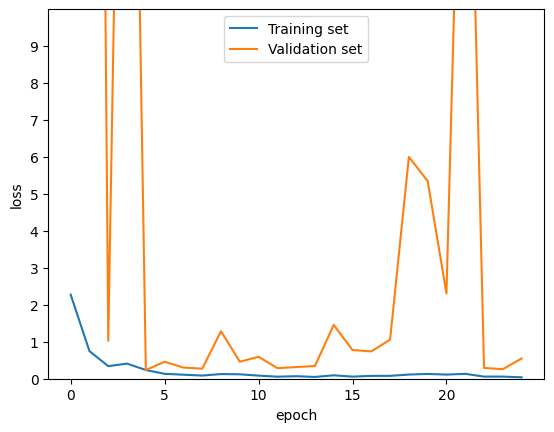

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 16, 2048)       23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 23630401 (90.14 MB)
Trainable params: 23584961 (89.97 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [8]:
### Model learning curve and summary

from matplotlib import pyplot as plt

ylimLoss = 10

plt.plot(modelHistory.history['loss'], label = "Training set")
plt.plot(modelHistory.history['val_loss'], label = "Validation set")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.xticks(np.arange(0,epochSize, 5))
plt.yticks(np.arange(0,ylimLoss, 1))
plt.ylim(bottom=0, top=ylimLoss)
plt.legend()

plt.show()

model.summary()


In [9]:
### Computing evalutation metrics

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

evalDic={}

evalDicName = path+"eval/{0}.{1}.loss_{2}.lr_{3}.optimizer_{4}.epoch_{5}.batch_{6}.\
nodes_{7}.unfrozen_{8}.actFx_{9}.time_{10}.eval".format(preTrained, whichMask,
                                                               lossFxShort,
                                                               learningRate,
                                                               optimizer,
                                                               epochSize,
                                                               batchSize,
                                                               denseLayerNodes,
                                                               unfrozenNaming,
                                                               activationFunction,
                                                               modelTime)

Y_pred = model.predict(X_test)
Y_gold = Y_test.reshape(-1,1)

mse_val = mean_squared_error(Y_gold, Y_pred)
rmse_val = mean_squared_error(Y_gold, Y_pred, squared=False)
mae_val = mean_absolute_error(Y_gold, Y_pred)
mape_val = mean_absolute_percentage_error(Y_gold, Y_pred)
r2_val = r2_score(Y_gold, Y_pred)

evalDic["subj"]=np.array(subj_test_li).reshape(-1, 1)
evalDic["pred"]=Y_pred
evalDic["gold"]=Y_gold

evalDic["mse"]=mse_val
evalDic["rmse"]=rmse_val
evalDic["mae"]=mae_val
evalDic["mape"]=mape_val
evalDic["r2"]=r2_val

with open(evalDicName, 'wb') as file_pi:
        pickle.dump(evalDic, file_pi)
    
print("Evaluation done")

10/10 [==============================] - 2s 99ms/step
Evaluation done


Mean-squared error: 0.5470047293449912
Mean absolute error: 0.5977108605702718
Mean absolute percentage error: 0.09688406564134576
R2: 0.7296516988410258


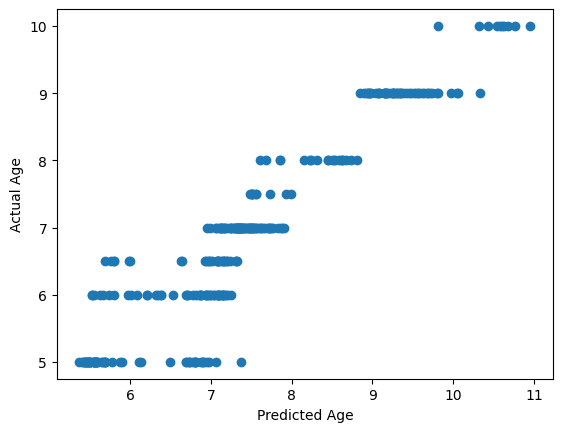

In [11]:
### Quick visualization of evaluation metrics

from matplotlib import pyplot as plt

print("Mean-squared error: {0}".format(evalDic["mse"]))
print("Root mean-squared error: {0}".format(evalDic["rmse"]))

print("Mean absolute error: {0}".format(evalDic["mae"]))
print("Mean absolute percentage error: {0}".format(evalDic["mape"]))
print("R2: {0}".format(evalDic["r2"]))

plt.scatter(evalDic["pred"], evalDic["gold"])
plt.xlabel("Predicted Age")
plt.ylabel("Actual Age")
plt.show()